# Pairwise Rank Centrality

This notebook explores pairwise rank centrality as a measure of model rankings. We recommend looking into Negahban, Sahand et al., (2016) [Rank Centrality: Ranking from Pairwise Comparisons](https://doi.org/10.1287/opre.2016.1534). Implemented at https://github.com/erensezener/rank-centrality/. 

Also see  Bana et al., (2021) [Convergence Voting](https://arxiv.org/abs/2102.01995) (no found code implementation).



We make our own implementation.

In [1]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import math
from collections import defaultdict
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns, pivot_to_wide_format
from src.viz.plot_config import *
from src.data_analysis.ranking import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)


# Set data path
PROJECT_ROOT = find_project_root()
CLUSTER_PATH = f"{PROJECT_ROOT}/results/clusters"
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/preference_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, metadata=False)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

## Prepping Data

In [2]:
model_name_mapping = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_mapping["long_name"], model_name_mapping["short_name"])
)

data_dict["utterances"]["model_name_orig"] = data_dict["utterances"][
    "model_name"
].copy()
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

In [3]:
utterances = data_dict["utterances"]
interactions = pivot_to_wide_format(data_dict["utterances"].copy())
data_dict["interactions"] = interactions

In [4]:
openers = interactions[interactions["turn"] == 0]
battles = pd.DataFrame(extract_battles(openers, tie_thresh=5))
display(battles.head())

# Remove ties
battles_no_ties = battles[~battles["winner"].str.contains("tie")]

# Value counts
print(f"Number of pairwise battles: {len(battles)}")
print(battles["winner"].value_counts(normalize=True))

,model_a,score_a,model_b,score_b,winner
0,flan-t5-xxl,17.0,command-light,92.0,model_b
1,claude-2.1,65.0,zephyr-7b-beta,83.0,model_b
2,claude-2.1,65.0,guanaco-33b,40.0,model_a
3,claude-2.1,65.0,llama-2-70b-chat,24.0,model_a
4,zephyr-7b-beta,83.0,guanaco-33b,40.0,model_a


Number of pairwise battles: 42306
winner
model_a    0.421902
model_b    0.403323
tie        0.174774
Name: proportion, dtype: float64


## Get comparisons

In [5]:
# We want a list of (winner, loser) pairs
tie_mask = battles["winner"] == "tie"
winner_a_mask = battles["winner"] == "model_a"
winner_b_mask = battles["winner"] == "model_b"

# Handle ties (double count but in reversed order)
ties = battles.loc[tie_mask, ["model_a", "model_b"]].values
tie_comparisons = np.concatenate([ties, ties[:, [1, 0]]])

# Handle non-ties
winner_a_comparisons = battles.loc[winner_a_mask, ["model_a", "model_b"]].values
winner_b_comparisons = battles.loc[winner_b_mask, ["model_b", "model_a"]].values

# Concatenate all comparisons
comparisons = np.concatenate(
    [tie_comparisons, winner_a_comparisons, winner_b_comparisons]
)

print(comparisons)
print(comparisons.shape)

[['pythia-12b' 'claude-2.1']
 ['zephyr-7b-beta' 'llama-2-7b-chat']
 ['mistral-7b-instruct' 'command-light']
 ...
 ['command-light' 'luminous-supreme-control']
 ['palm-2' 'command-nightly']
 ['palm-2' 'flan-t5-xxl']]
(49700, 2)


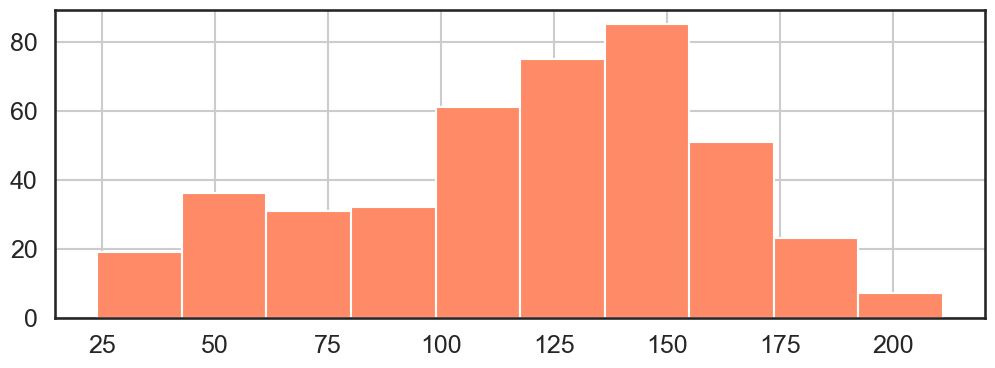

In [6]:
# Inspect
c_df = pd.DataFrame(comparisons, columns=["winners", "losers"])
c_df.value_counts().hist()
plt.show()

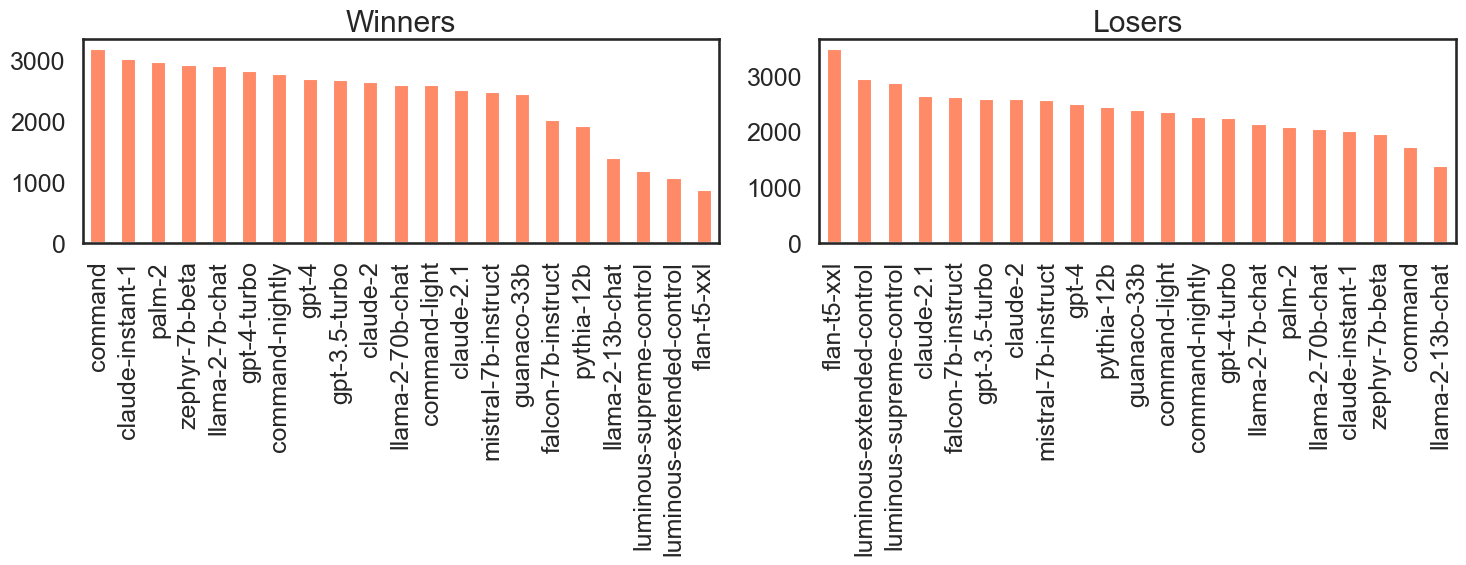

In [7]:
# Plot bar of winner and loser value counts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
c_df["winners"].value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_title("Winners")
ax[0].set_xlabel("")
c_df["losers"].value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_title("Losers")
ax[1].set_xlabel("")
plt.tight_layout()
plt.show()

In [8]:
# Get the winners in the order of their wins
unique_items = list(c_df["winners"].value_counts().index)
unique_losers = sorted(list(c_df["losers"].unique()))

# Add unique losers that are not already in the unique_items_ordered list
for loser in unique_losers:
    if loser not in unique_items:
        unique_items.append(loser)

# Get n items
n_items = len(unique_items)

# Inspect
print(f"The unique items to rank are:\n{unique_items}")
print(f"In total, there are {n_items} items")

The unique items to rank are:
['command', 'claude-instant-1', 'palm-2', 'zephyr-7b-beta', 'llama-2-7b-chat', 'gpt-4-turbo', 'command-nightly', 'gpt-4', 'gpt-3.5-turbo', 'claude-2', 'llama-2-70b-chat', 'command-light', 'claude-2.1', 'mistral-7b-instruct', 'guanaco-33b', 'falcon-7b-instruct', 'pythia-12b', 'llama-2-13b-chat', 'luminous-supreme-control', 'luminous-extended-control', 'flan-t5-xxl']
In total, there are 21 items


In [9]:
# Check (approx) limits
n = len(unique_items)
required = n * np.log(n)
print(required)

63.93497119219188


In [10]:
# Set up a dictionary to store the results (currently ordered in number of pairwise wins)
item2index = {item: i for i, item in enumerate(unique_items)}
item2index

{'command': 0,
 'claude-instant-1': 1,
 'palm-2': 2,
 'zephyr-7b-beta': 3,
 'llama-2-7b-chat': 4,
 'gpt-4-turbo': 5,
 'command-nightly': 6,
 'gpt-4': 7,
 'gpt-3.5-turbo': 8,
 'claude-2': 9,
 'llama-2-70b-chat': 10,
 'command-light': 11,
 'claude-2.1': 12,
 'mistral-7b-instruct': 13,
 'guanaco-33b': 14,
 'falcon-7b-instruct': 15,
 'pythia-12b': 16,
 'llama-2-13b-chat': 17,
 'luminous-supreme-control': 18,
 'luminous-extended-control': 19,
 'flan-t5-xxl': 20}

## Helper Funcs

In [11]:
# Little heatmap function to keep track of matrices
def matrix2heatmap(M, item2index):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.heatmap(
        M,
        ax=ax,
        cmap=palettes_dict["bam"],
        square=True,
    )
    ax.set_xticklabels(item2index.keys(), rotation=90)
    # Set ticks to 21
    ax.set_yticks(np.arange(0.5, 21.5, 1))
    ax.set_yticklabels(item2index.keys(), rotation=0, va="center")
    plt.show()

## Rank Centrality Implementation

### Initialisation

In [12]:
# Alpha is the regularization param
# Recommended prior of 1 is pretty good, can also be 0 for no regularization
alpha = 1

# Set up the transition matrix A of 1s (with reg param)
A = np.ones((len(unique_items), len(unique_items))) * alpha

# Fill the diagonals with 0 (self-loops)
np.fill_diagonal(A, 0)
print(A.shape)

(21, 21)


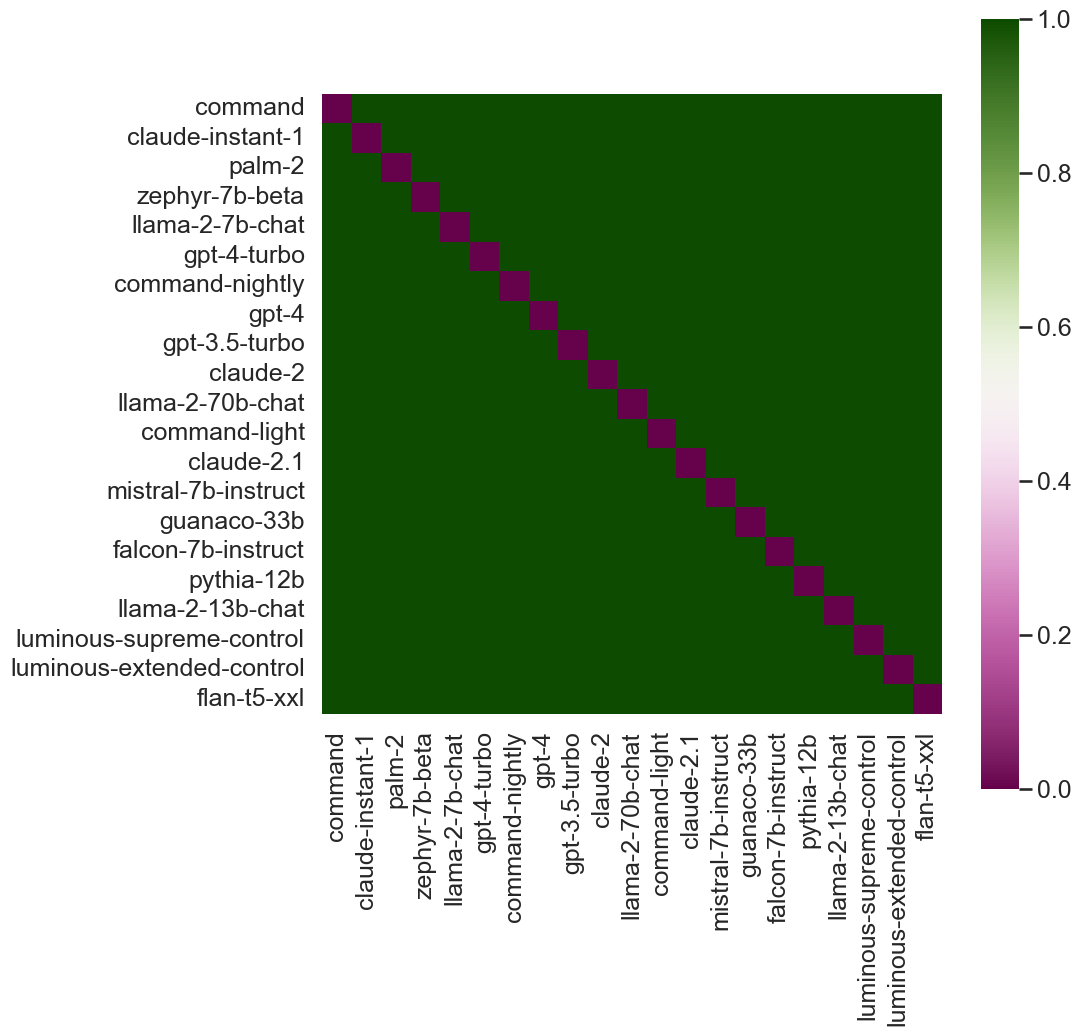

In [13]:
# Let's check out A (should be uniform color)
matrix2heatmap(A, item2index)

### Populate win matrix with number of wins and losses

In [14]:
for w, l in comparisons:
    # Rows are the winning model, column is losing model
    A[item2index[w], item2index[l]] += 1

    A_sum = (
        A[np.triu_indices_from(A, 1)] + A[np.tril_indices_from(A, -1)]
    ) + 1e-6  # to prevent division by zero

In [15]:
# Inspect
print(A[0])
print(A.shape)
print(A_sum.shape)  # Note this is 21C2 (number of combinations)

[  0. 149. 146. 147. 156. 158. 183. 174. 178. 169. 158. 180. 183. 154.
 156. 167. 146.  90. 176. 158. 180.]
(21, 21)
(210,)


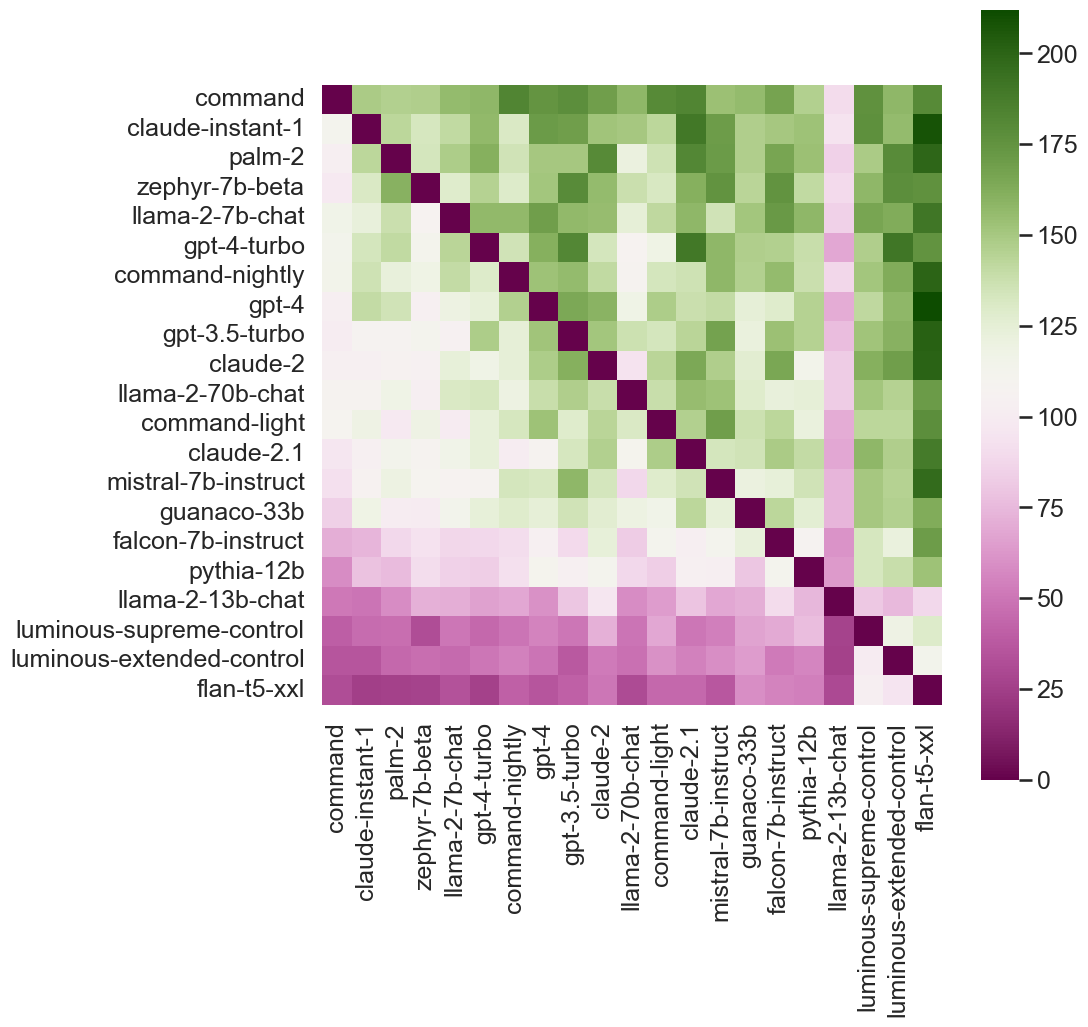

In [16]:
# Inspect again
matrix2heatmap(A, item2index)

We can interpret this as follows:
* Chose a column e.g., Flan.
* Going up the column, we see the number of wins that __other__ models have against flan. The darker the green, the more they win. So Claude-instant-1 clocks up lots of wins against flan. Llama-2-13b clocks up way less wins.


The problem is this is still affected by absolute counts of model appearances which we know is not stable across models

### Normalisation by Ratio of Pairwise Battles

<Axes: ylabel='Density'>

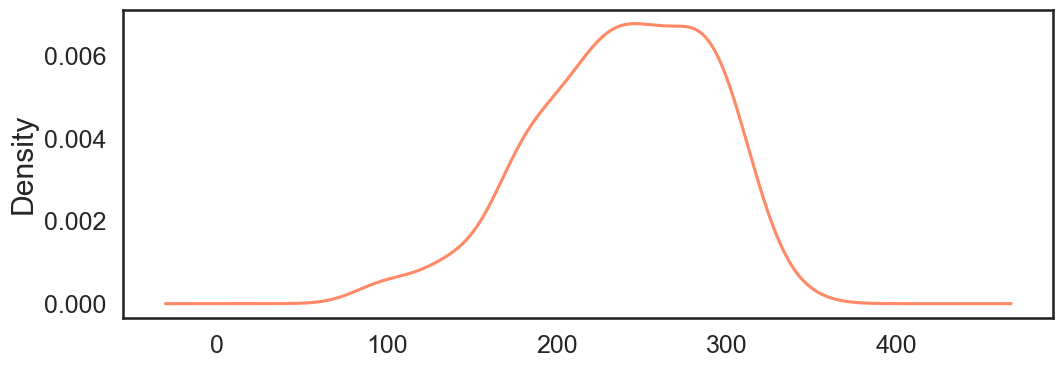

In [17]:
pd.Series(A_sum).plot(kind="kde")

In [18]:
# Normalise by A_sum
A[np.triu_indices_from(A, 1)] /= A_sum
A[np.tril_indices_from(A, -1)] /= A_sum

print(A[0])

[0.         0.57088122 0.58870968 0.50689655 0.61417323 0.5467128
 0.5335277  0.6        0.59136212 0.5504886  0.59622641 0.6122449
 0.57728706 0.5220339  0.57992565 0.53697749 0.55938697 0.39823009
 0.58862876 0.57246377 0.5625    ]


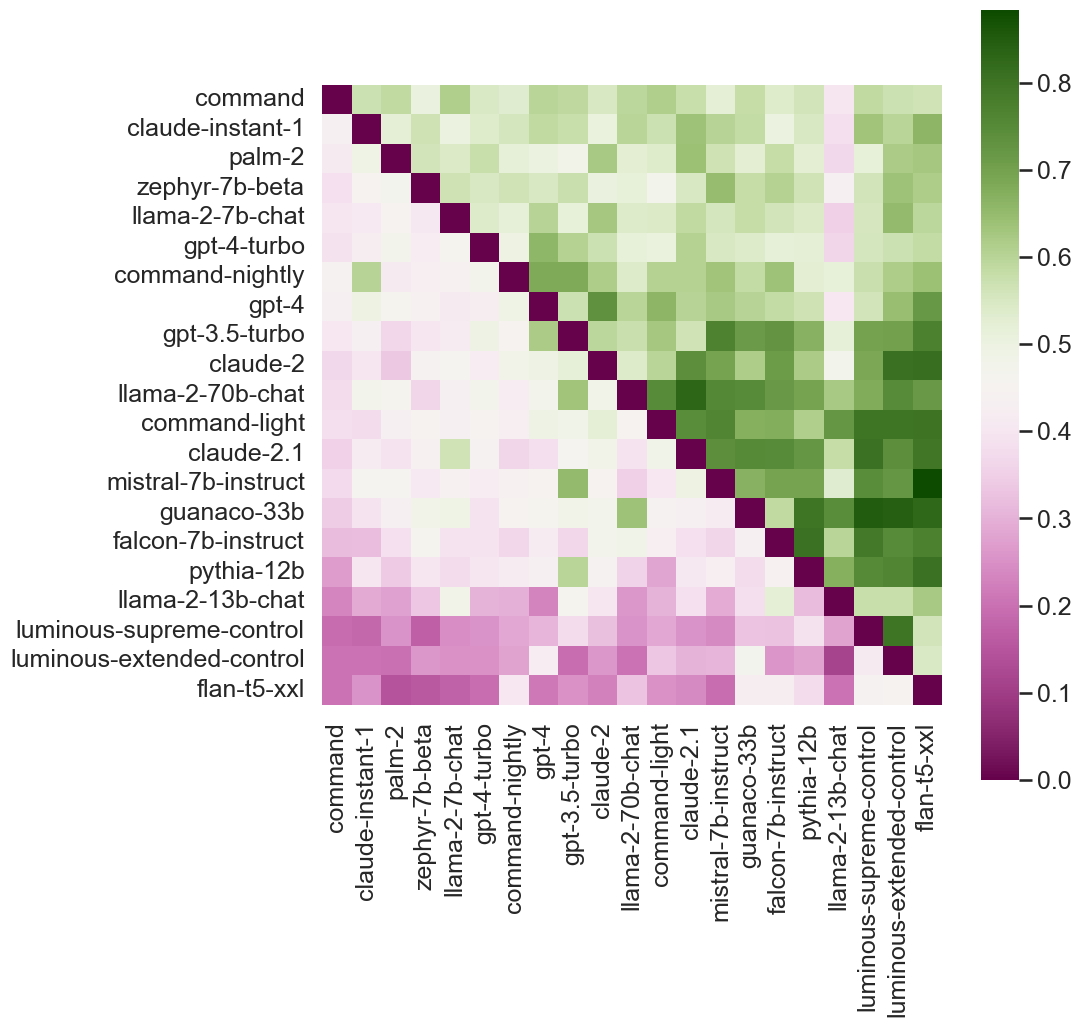

In [19]:
# Let's check out the matrix now we've normalised
matrix2heatmap(A, item2index)

Now we have the proportions of wins between a pair of models.

### Adjusting Movement from One Node to Other Nodes

Now we times the matrix by 1/dmax (because at each node there is a uniform chance of picking any of the other nodes, besides from the ego), so dmax is the maximum out-degree (aka n_models - 1)


In [20]:
# Max degree
d_max = len(unique_items) - 1
print(d_max)

A /= d_max

20


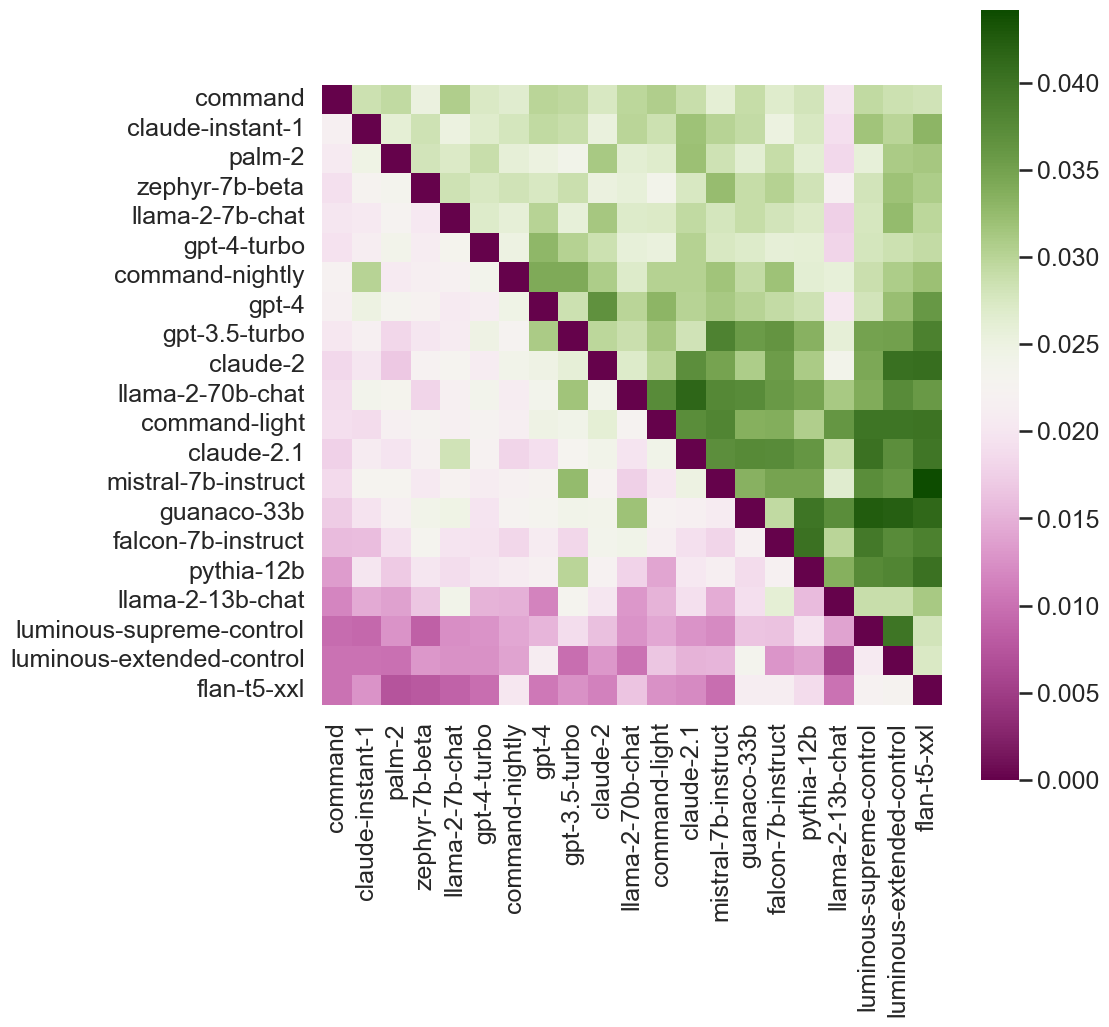

In [21]:
# Nothing should have changed here, it's just a scaling factor
matrix2heatmap(A, item2index)

Note, these are not quite yet probabilities - they won't sum to 1 because we haven't added the self-loops

### Self Loops (Diagonals)

For each node, we now need to sort the diagonal - the probability of returning to the node itself (based on the residual probabilities)

In [22]:
# Find residual probability per column
residuals = 1 - np.sum(A, axis=0)
print(residuals)

[0.65507957 0.5977994  0.60738184 0.59600797 0.56490996 0.57274607
 0.56228178 0.52094651 0.49665501 0.50675344 0.53641167 0.51532633
 0.47062617 0.46745036 0.44278698 0.43234034 0.43344351 0.53635942
 0.36143176 0.31963461 0.30362737]


In [23]:
# Fill the diagonal with the residuals
np.fill_diagonal(A, residuals)

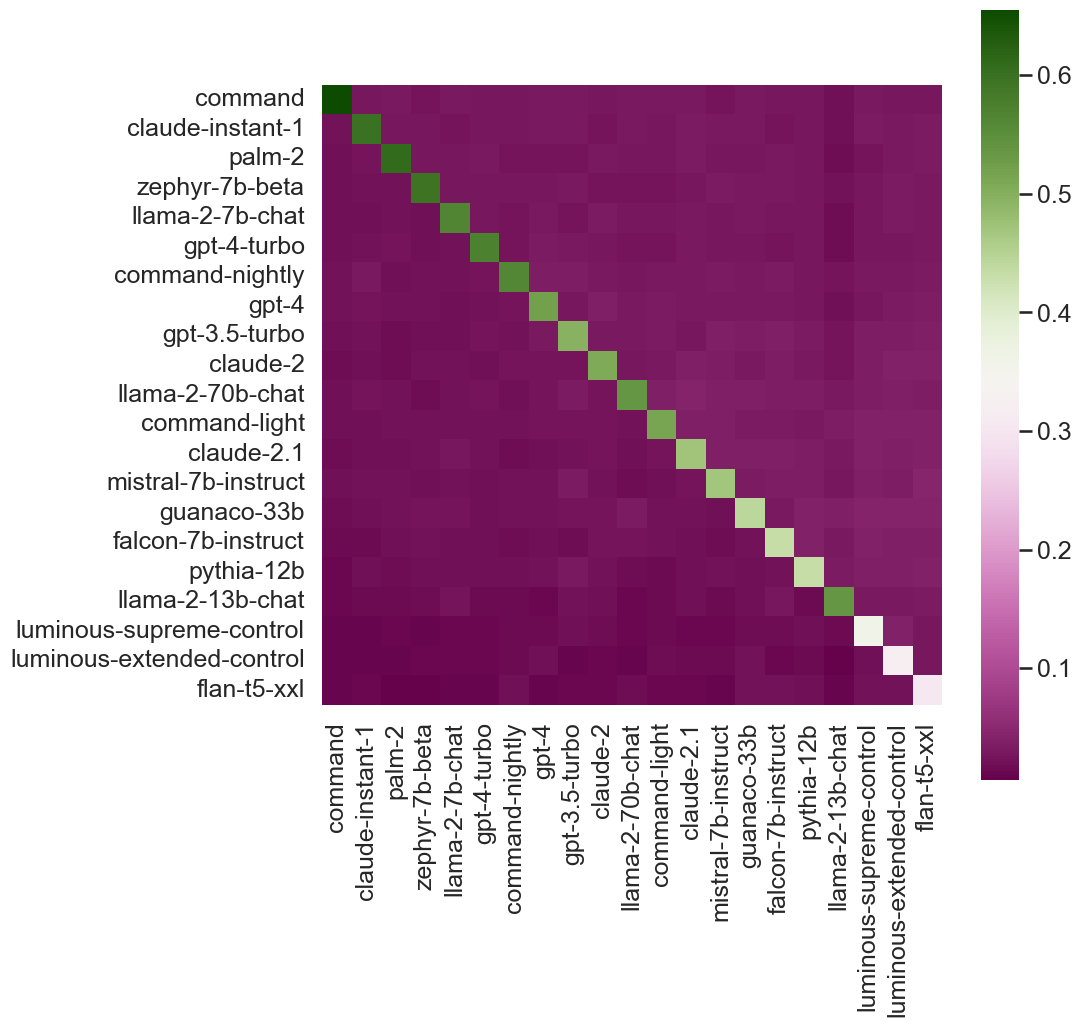

In [24]:
# Let's check it out again
matrix2heatmap(A, item2index)

Note that there is a big bias towards staying where you are but each node has that bias.

### Getting the Steady State

In [25]:
# Define a vector - so long as sums to 1 and is positive, it is a valid probability distribution
# Uniform over all items
vec = np.array([1 / len(unique_items)] * len(unique_items))
vec

array([0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905])

In [26]:
# Solve via iterations
iterations = 1000
scores = np.matmul(np.linalg.matrix_power(A, iterations), vec)

### Getting the Scores

In [27]:
# Assign the scores to our storage dictionary
score_dict = {item: scores[index] for item, index in item2index.items()}
score_dict

{'command': 0.0753677157818229,
 'claude-instant-1': 0.06367025834162537,
 'palm-2': 0.06322882850749767,
 'zephyr-7b-beta': 0.06126301295034037,
 'llama-2-7b-chat': 0.05571227480900393,
 'gpt-4-turbo': 0.05600642943572768,
 'command-nightly': 0.05913391165765886,
 'gpt-4': 0.05288964460102576,
 'gpt-3.5-turbo': 0.051058974352968946,
 'claude-2': 0.05032279389161809,
 'llama-2-70b-chat': 0.05676590628939451,
 'command-light': 0.05186594221265458,
 'claude-2.1': 0.045805640750251876,
 'mistral-7b-instruct': 0.04455427831091278,
 'guanaco-33b': 0.04321477177792962,
 'falcon-7b-instruct': 0.037425411631537835,
 'pythia-12b': 0.03619011096611666,
 'llama-2-13b-chat': 0.03604903585789168,
 'luminous-supreme-control': 0.021685504872389724,
 'luminous-extended-control': 0.019493827664706406,
 'flan-t5-xxl': 0.01829572533693387}

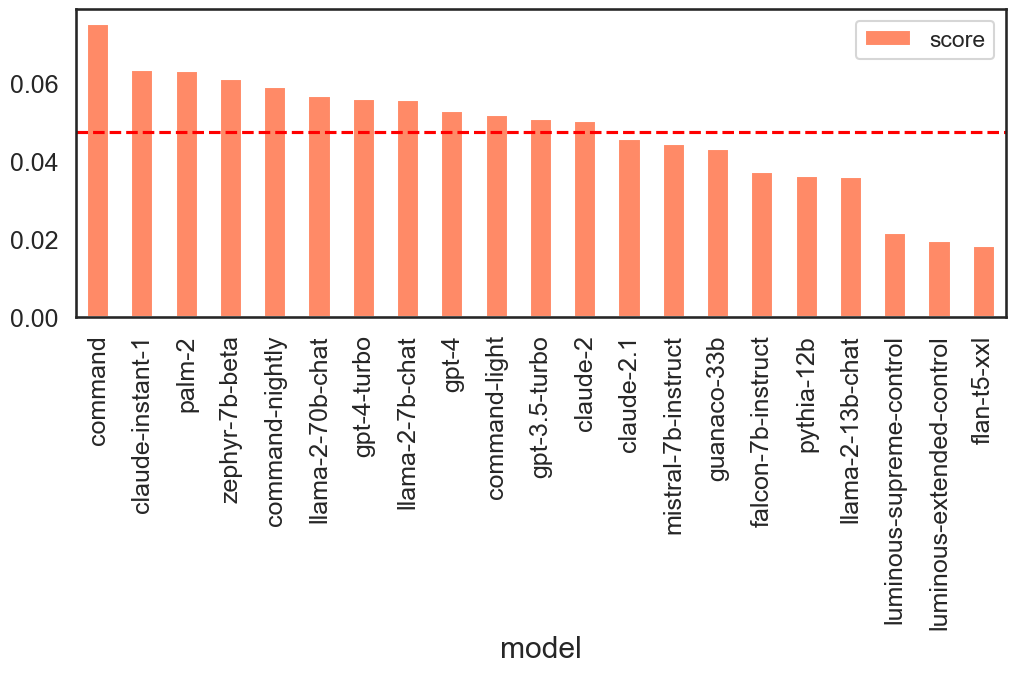

In [28]:
# Plot scores
score_df = pd.DataFrame(score_dict.items(), columns=["model", "score"])
score_df = score_df.sort_values("score", ascending=False)
score_df.plot(kind="bar", x="model", y="score")
# Plot line at 1/21
plt.axhline(1 / len(score_dict.keys()), color="red", linestyle="--")
plt.show()

## Putting Together as Function

This is the function that is in `ranking.py`.

In [29]:
def compute_rank_centrality(battles, iterations=1000, alpha=1):
    tie_mask = battles["winner"] == "tie"
    winner_a_mask = battles["winner"] == "model_a"
    winner_b_mask = battles["winner"] == "model_b"

    # Handle ties
    ties = battles.loc[tie_mask, ["model_a", "model_b"]].values
    tie_comparisons = np.concatenate([ties, ties[:, [1, 0]]])

    # Handle non-ties
    winner_a_comparisons = battles.loc[winner_a_mask, ["model_a", "model_b"]].values
    winner_b_comparisons = battles.loc[winner_b_mask, ["model_b", "model_a"]].values

    # Concatenate all comparisons
    comparisons = np.concatenate(
        [tie_comparisons, winner_a_comparisons, winner_b_comparisons]
    )
    c_df = pd.DataFrame(comparisons, columns=["winners", "losers"])

    # Default to order of winners
    unique_items = list(c_df["winners"].value_counts().index)
    unique_losers = sorted(list(c_df["losers"].unique()))

    # Add unique losers that are not already in the unique_items_ordered list
    for loser in unique_losers:
        if loser not in unique_items:
            unique_items.append(loser)

    # Get n items
    n_items = len(unique_items)

    # Get item2index
    item2index = {item: i for i, item in enumerate(unique_items)}

    # Set up the transition matrix A of 1s (with reg param)
    A = np.ones((len(unique_items), len(unique_items))) * alpha

    # Fill the diagonals with 0 (self-loops)
    np.fill_diagonal(A, 0)

    # Populate transition matrix
    for w, l in comparisons:
        # Rows are the winning model, column is losing model
        A[item2index[w], item2index[l]] += 1

        A_sum = (
            A[np.triu_indices_from(A, 1)] + A[np.tril_indices_from(A, -1)]
        ) + 1e-6  # to prevent division by zero

    # Normalise by ratio
    A[np.triu_indices_from(A, 1)] /= A_sum
    A[np.tril_indices_from(A, -1)] /= A_sum

    # Normalise by max degree
    d_max = n_items - 1
    A /= d_max

    # Add self-loop probabilities
    # Find residual probability per column
    residuals = 1 - np.sum(A, axis=0)

    # Fill the diagonal with the residuals
    np.fill_diagonal(A, residuals)

    # Get steady state by iters
    vec = np.array([1 / n_items] * n_items)
    scores = np.matmul(np.linalg.matrix_power(A, iterations), vec)

    score_dict = {item: scores[index] for item, index in item2index.items()}

    return score_dict

In [30]:
score_dict = compute_rank_centrality(battles, alpha=1)
score_df = pd.DataFrame(score_dict.items(), columns=["model", "score"])

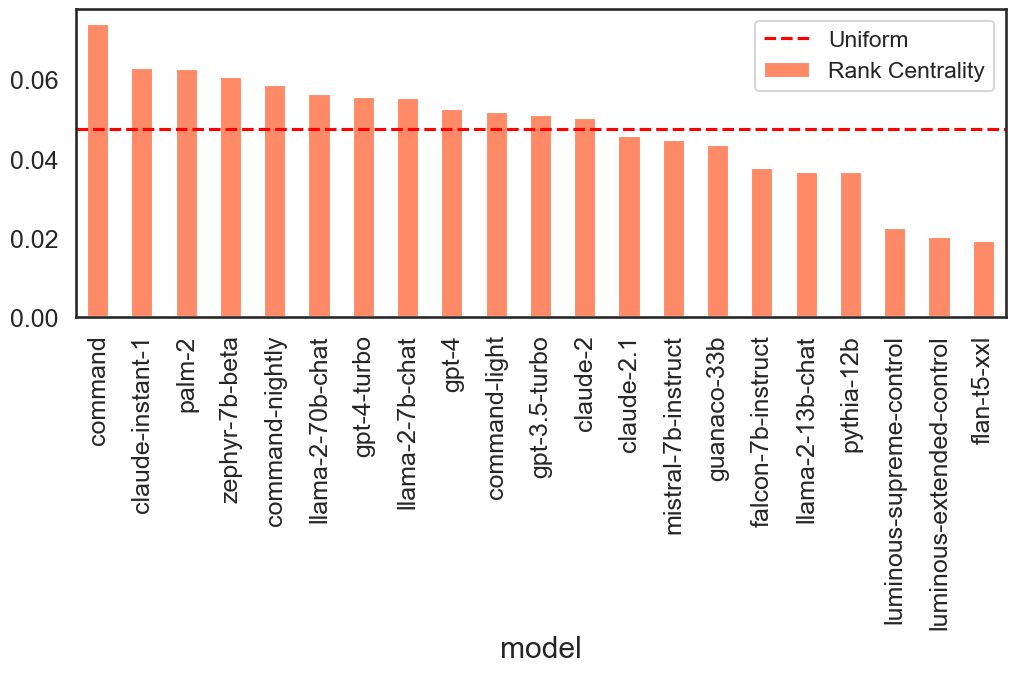

In [31]:
# Plot
def plot_rank_centrality(score_dict):
    score_df = pd.DataFrame(score_dict.items(), columns=["model", "score"])
    score_df = score_df.sort_values("score", ascending=False)
    score_df.plot(kind="bar", x="model", y="score", label="Rank Centrality")
    # Plot line at 1/21
    plt.axhline(
        1 / len(score_dict.keys()), color="red", linestyle="--", label="Uniform"
    )
    plt.legend()
    plt.show()


score_dict = compute_rank_centrality(battles, alpha=5)
plot_rank_centrality(score_dict)